# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
comp_name = 'us-patent-phrase-to-phrase-matching'
nb_name = 'nb004t-deberta-v3-large'

import sys
print(sys.version)
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    base = f"/content/drive/MyDrive/colab_notebooks/kaggle/{comp_name}/notebooks"
    %cd {base}


import os
INPUT_DIR = f'../input/{comp_name}/'
if 'kaggle_web_client' in sys.modules:
    OUTPUT_DIR = './'
else:
    OUTPUT_DIR = f'../input/{nb_name}/'
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/colab_notebooks/kaggle/us-patent-phrase-to-phrase-matching/notebooks


# CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    wandb=True
    wandbproject=comp_name
    wandbgroup=nb_name
    wandbname='exp001'
    _wandb_kernel='riow1983'
    apex=True
    print_freq=100
    num_workers=8
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=8 #16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]
    CFG.wandbname = 'debug'

In [3]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    if 'google.colab' in sys.modules:
        !pip install wandb
    import wandb

    try:
        if 'kaggle_web_client' in sys.modules:
            from kaggle_secrets import UserSecretsClient
            user_secrets = UserSecretsClient()
            secret_value_0 = user_secrets.get_secret("wandb_api")
        else:
            import json
            f = open("../../wandb.json", "r")
            json_data = json.load(f)
            secret_value_0 = json_data["wandb_api"]
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))
    
    run = wandb.init(
        dir=OUTPUT_DIR,
        project=CFG.wandbproject,
        group=CFG.wandbgroup,
        name=CFG.wandbname, 
        config=class2dict(CFG),
        job_type="train",
        anonymous=anony)
    print(f"wandb run id: {run.id}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


wandb: Currently logged in as: riow1983. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb run id: 2h10fk10


# Library

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold


# # PyTorchのバージョンを1.10.1に下げる (Google Colabなのでpipでやる)
# os.system('pip uninstall -y torch torchvision torchaudio')
# os.system('pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html')


import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
# os.system('python -m pip install transformers')
# os.system('python -m pip install tokenizers')
os.system('pip install sentencepiece')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.10.1+cu111
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [7]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [8]:
# train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
# test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']

train['text'] = train['anchor'] + '[SEP]' + train['target']
test['text'] = test['anchor'] + '[SEP]' + test['target']

train['text2'] = train['context_text']
test['text2'] = test['context_text']


display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text,text2
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text,text,text2
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural network,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


# EDA

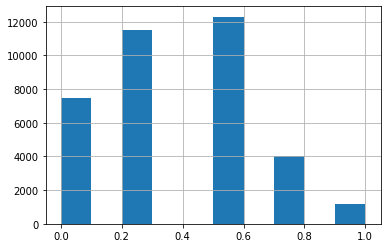

In [9]:
train['score'].hist()

In [10]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [11]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [12]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [13]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [14]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
# CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
#                 + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
CFG.max_len = max(max(lengths_dict['anchor'])+max(lengths_dict['target'])+3, max(lengths_dict['context_text'])+2)
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 87


In [15]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.texts2 = df['text2'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        inputs2 = prepare_input(self.cfg, self.texts2[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, inputs2, label

In [16]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [17]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs, inputs2):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        
        outputs2 = self.model(**inputs2)
        last_hidden_states2 = outputs2[0]
        
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        feature2 = torch.mean(last_hidden_states2, dim=1)
        feature += feature2
        return feature

    def forward(self, inputs, inputs2):
        feature = self.feature(inputs, inputs2)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [18]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, inputs2, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        for k, v in inputs2.items():
            inputs2[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs, inputs2)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, inputs2, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        for k, v in inputs2.items():
            inputs2[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs, inputs2)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs[0].items():
            inputs[0][k] = v.to(device)
        for k, v in inputs[1].items():
            inputs[1][k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs[0], inputs[1])
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [19]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()




    # Push to LINE
    import requests

    def send_line_notification(message):
        import json
        f = open("../../line.json", "r")
        json_data = json.load(f)
        line_token = json_data["kagglePush"]
        endpoint = 'https://notify-api.line.me/api/notify'
        message = "\n{}".format(message)
        payload = {'message': message}
        headers = {'Authorization': 'Bearer {}'.format(line_token)}
        requests.post(endpoint, data=payload, headers=headers)

    if CFG.wandb:
        send_line_notification(f"Training of {CFG.wandbproject+'/'+CFG.wandbgroup+'/'+CFG.wandbname} has been done. See {run.url}")
    else:
        send_line_notification(f"Training of {CFG.wandbproject+'/'+CFG.wandbgroup+'/'+CFG.wandbname} has been done.")

========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

Epoch: [1][0/3419] Elapsed 0m 0s (remain 56m 36s) Loss: 0.7294(0.7294) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 40s (remain 22m 24s) Loss: 0.5789(0.6813) Grad: 67163.4922  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 20s (remain 21m 26s) Loss: 0.6969(0.6673) Grad: 71148.6094  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 1m 59s (remain 20m 42s) Loss: 0.6521(0.6699) Grad: 24516.2871  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 2m 39s (remain 20m 0s) Loss: 0.6238(0.6691) Grad: 10742.6875  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 3m 18s (remain 19m 17s) Loss: 0.6854(0.6666) Grad: 18472.8301  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 3m 58s (remain 18m 40s) Loss: 0.6572(0.6659) Grad: 10327.2090  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 4m 39s (remain 18m 3s) Loss: 0.5582(0.6640) Grad: 29605.9395  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 5m 19s (remain 17m 22s) Loss: 0.6379(0.6615) Grad: 26502.5527  LR: 0.00001983  
Epoch: [1][900/3419] Elapsed 5m

Epoch 1 - avg_train_loss: 0.6547  avg_val_loss: 0.6437  time: 1508s
Epoch 1 - Score: 0.2681
Epoch 1 - Save Best Score: 0.2681 Model


EVAL: [1139/1140] Elapsed 2m 35s (remain 0m 0s) Loss: 0.7854(0.6437) 
Epoch: [2][0/3419] Elapsed 0m 0s (remain 52m 31s) Loss: 0.7092(0.7092) Grad: 73697.8750  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 41s (remain 22m 49s) Loss: 0.6403(0.6563) Grad: 46006.4102  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 1m 20s (remain 21m 28s) Loss: 0.7105(0.6509) Grad: 26141.0996  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 1m 58s (remain 20m 30s) Loss: 0.6521(0.6505) Grad: 23596.3516  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 2m 38s (remain 19m 50s) Loss: 0.6928(0.6495) Grad: 12799.0977  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 3m 17s (remain 19m 10s) Loss: 0.6288(0.6494) Grad: 9811.8154  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 3m 57s (remain 18m 33s) Loss: 0.7313(0.6498) Grad: 20969.2812  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 4m 37s (remain 17m 56s) Loss: 0.6318(0.6473) Grad: 29440.7910  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 5m 16s (remain 17m 15s) Loss: 0.5

Epoch 2 - avg_train_loss: 0.5832  avg_val_loss: 0.5497  time: 1516s
Epoch 2 - Score: 0.8243
Epoch 2 - Save Best Score: 0.8243 Model


EVAL: [1139/1140] Elapsed 2m 36s (remain 0m 0s) Loss: 0.6140(0.5497) 
Epoch: [3][0/3419] Elapsed 0m 0s (remain 53m 0s) Loss: 0.5487(0.5487) Grad: 164654.0312  LR: 0.00001000  
Epoch: [3][100/3419] Elapsed 0m 42s (remain 23m 3s) Loss: 0.5177(0.5308) Grad: 132391.5156  LR: 0.00000977  
Epoch: [3][200/3419] Elapsed 1m 22s (remain 21m 53s) Loss: 0.6038(0.5349) Grad: 52433.4727  LR: 0.00000954  
Epoch: [3][300/3419] Elapsed 2m 1s (remain 21m 1s) Loss: 0.4794(0.5265) Grad: 35685.5547  LR: 0.00000931  
Epoch: [3][400/3419] Elapsed 2m 41s (remain 20m 15s) Loss: 0.5698(0.5296) Grad: 20176.9824  LR: 0.00000908  
Epoch: [3][500/3419] Elapsed 3m 21s (remain 19m 31s) Loss: 0.4878(0.5302) Grad: 42822.7734  LR: 0.00000885  
Epoch: [3][600/3419] Elapsed 4m 0s (remain 18m 49s) Loss: 0.5839(0.5312) Grad: 27220.2246  LR: 0.00000863  
Epoch: [3][700/3419] Elapsed 4m 40s (remain 18m 7s) Loss: 0.6003(0.5335) Grad: 67777.2891  LR: 0.00000840  
Epoch: [3][800/3419] Elapsed 5m 20s (remain 17m 27s) Loss: 0.5432

Epoch 3 - avg_train_loss: 0.5282  avg_val_loss: 0.5465  time: 1510s
Epoch 3 - Score: 0.8404
Epoch 3 - Save Best Score: 0.8404 Model


EVAL: [1139/1140] Elapsed 2m 34s (remain 0m 0s) Loss: 0.6068(0.5465) 
Epoch: [4][0/3419] Elapsed 0m 0s (remain 53m 40s) Loss: 0.5680(0.5680) Grad: 29184.1992  LR: 0.00000293  
Epoch: [4][100/3419] Elapsed 0m 41s (remain 22m 49s) Loss: 0.4673(0.5111) Grad: 449728.1562  LR: 0.00000277  
Epoch: [4][200/3419] Elapsed 1m 21s (remain 21m 40s) Loss: 0.6137(0.5139) Grad: 82014.2422  LR: 0.00000261  
Epoch: [4][300/3419] Elapsed 2m 0s (remain 20m 52s) Loss: 0.6115(0.5167) Grad: 46574.0039  LR: 0.00000246  
Epoch: [4][400/3419] Elapsed 2m 40s (remain 20m 6s) Loss: 0.4653(0.5191) Grad: 40291.1211  LR: 0.00000231  
Epoch: [4][500/3419] Elapsed 3m 19s (remain 19m 22s) Loss: 0.5268(0.5156) Grad: 83615.7656  LR: 0.00000216  
Epoch: [4][600/3419] Elapsed 3m 59s (remain 18m 41s) Loss: 0.4863(0.5136) Grad: 228298.3438  LR: 0.00000202  
Epoch: [4][700/3419] Elapsed 4m 37s (remain 17m 57s) Loss: 0.5844(0.5137) Grad: 143847.1562  LR: 0.00000189  
Epoch: [4][800/3419] Elapsed 5m 16s (remain 17m 15s) Loss: 0

Epoch 4 - avg_train_loss: 0.5177  avg_val_loss: 0.5487  time: 1504s
Epoch 4 - Score: 0.8428
Epoch 4 - Save Best Score: 0.8428 Model


EVAL: [1139/1140] Elapsed 2m 34s (remain 0m 0s) Loss: 0.6096(0.5487) 


========== fold: 0 result ==========
Score: 0.8428
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/3419] Elapsed 0m 0s (remain 53m 25s) Loss: 0.8393(0.8393) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 41s (remain 22m 47s) Loss: 0.6465(0.6633) Grad: 29671.3184  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 20s (remain 21m 20s) Loss: 0.5528(0.6335) Grad: 17145.2012  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 1m 58s (remain 20m 30s) Loss: 0.5714(0.6220) Grad: 28590.0840  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 2m 37s (remain 19m 47s) Loss: 0.5374(0.6117) Grad: 24813.6152  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 3m 16s (remain 19m 5s) Loss: 0.5146(0.6071) Grad: 11630.8086  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 3m 55s (remain 18m 22s) Loss: 0.4292(0.6005) Grad: 25590.7578  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 4m 34s (remain 17m 42s) Loss: 0.5923(0.5958) Grad: 29269.9629  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 5m 12s (remain 17m 2s) Loss: 0.6691(0.5912) Grad: 22496.9766  LR: 0.00001983  
Epoch: [1][900/3419] Elapsed 5m

Epoch 1 - avg_train_loss: 0.5659  avg_val_loss: 0.5384  time: 1488s
Epoch 1 - Score: 0.8335
Epoch 1 - Save Best Score: 0.8335 Model


EVAL: [1139/1140] Elapsed 2m 35s (remain 0m 0s) Loss: 0.7110(0.5384) 
Epoch: [2][0/3419] Elapsed 0m 0s (remain 55m 28s) Loss: 0.5796(0.5796) Grad: 120370.5625  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 41s (remain 22m 54s) Loss: 0.5763(0.5189) Grad: 51173.3164  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 1m 21s (remain 21m 42s) Loss: 0.5062(0.5223) Grad: 55314.9648  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 2m 0s (remain 20m 52s) Loss: 0.4661(0.5154) Grad: 65454.0430  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 2m 41s (remain 20m 14s) Loss: 0.3904(0.5196) Grad: 381713.5938  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 3m 21s (remain 19m 33s) Loss: 0.5767(0.5199) Grad: 109983.0469  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 4m 1s (remain 18m 52s) Loss: 0.5150(0.5196) Grad: 233462.0312  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 4m 41s (remain 18m 10s) Loss: 0.6266(0.5180) Grad: 458444.9062  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 5m 21s (remain 17m 29s) Loss:

Epoch 2 - avg_train_loss: 0.5240  avg_val_loss: 0.5524  time: 1528s
Epoch 2 - Score: 0.8357
Epoch 2 - Save Best Score: 0.8357 Model


EVAL: [1139/1140] Elapsed 2m 36s (remain 0m 0s) Loss: 0.5847(0.5524) 
Epoch: [3][0/3419] Elapsed 0m 0s (remain 55m 16s) Loss: 0.6982(0.6982) Grad: 212661.3750  LR: 0.00001000  
Epoch: [3][100/3419] Elapsed 0m 42s (remain 23m 20s) Loss: 0.4823(0.4999) Grad: 85960.2891  LR: 0.00000977  
Epoch: [3][200/3419] Elapsed 1m 22s (remain 22m 8s) Loss: 0.5271(0.5155) Grad: 13932.2490  LR: 0.00000954  
Epoch: [3][300/3419] Elapsed 2m 3s (remain 21m 21s) Loss: 0.5053(0.5072) Grad: 52239.4062  LR: 0.00000931  
Epoch: [3][400/3419] Elapsed 2m 43s (remain 20m 32s) Loss: 0.5629(0.5121) Grad: 81424.9922  LR: 0.00000908  
Epoch: [3][500/3419] Elapsed 3m 23s (remain 19m 46s) Loss: 0.4971(0.5116) Grad: 20230.7070  LR: 0.00000885  
Epoch: [3][600/3419] Elapsed 4m 4s (remain 19m 4s) Loss: 0.4727(0.5116) Grad: 46390.7734  LR: 0.00000863  
Epoch: [3][700/3419] Elapsed 4m 43s (remain 18m 17s) Loss: 0.4622(0.5124) Grad: 5292.3398  LR: 0.00000840  
Epoch: [3][800/3419] Elapsed 5m 23s (remain 17m 35s) Loss: 0.6511

Epoch 3 - avg_train_loss: 0.5094  avg_val_loss: 0.5516  time: 1520s
Epoch 3 - Score: 0.8494
Epoch 3 - Save Best Score: 0.8494 Model


EVAL: [1139/1140] Elapsed 2m 34s (remain 0m 0s) Loss: 0.5713(0.5516) 
Epoch: [4][0/3419] Elapsed 0m 0s (remain 56m 4s) Loss: 0.3454(0.3454) Grad: 37988.3125  LR: 0.00000293  
Epoch: [4][100/3419] Elapsed 0m 42s (remain 23m 21s) Loss: 0.5631(0.4800) Grad: 71517.1406  LR: 0.00000277  
Epoch: [4][200/3419] Elapsed 1m 22s (remain 21m 58s) Loss: 0.3728(0.4846) Grad: 33629.8320  LR: 0.00000261  
Epoch: [4][300/3419] Elapsed 2m 2s (remain 21m 7s) Loss: 0.5923(0.4864) Grad: 48389.3242  LR: 0.00000246  
Epoch: [4][400/3419] Elapsed 2m 42s (remain 20m 21s) Loss: 0.5121(0.4934) Grad: 9808.2920  LR: 0.00000231  
Epoch: [4][500/3419] Elapsed 3m 21s (remain 19m 35s) Loss: 0.6342(0.4959) Grad: 16696.8496  LR: 0.00000216  
Epoch: [4][600/3419] Elapsed 4m 1s (remain 18m 52s) Loss: 0.5358(0.5002) Grad: 11971.3193  LR: 0.00000202  
Epoch: [4][700/3419] Elapsed 4m 40s (remain 18m 9s) Loss: 0.2865(0.4993) Grad: 7572.1128  LR: 0.00000189  
Epoch: [4][800/3419] Elapsed 5m 20s (remain 17m 27s) Loss: 0.6103(0.

Epoch 4 - avg_train_loss: 0.4989  avg_val_loss: 0.5582  time: 1495s
Epoch 4 - Score: 0.8479


EVAL: [1139/1140] Elapsed 2m 34s (remain 0m 0s) Loss: 0.5637(0.5582) 


========== fold: 1 result ==========
Score: 0.8494
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/3419] Elapsed 0m 0s (remain 53m 0s) Loss: 0.7510(0.7510) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 39s (remain 21m 38s) Loss: 0.6483(0.6881) Grad: 50431.6758  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 18s (remain 20m 52s) Loss: 0.7374(0.6752) Grad: 41153.9492  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 1m 57s (remain 20m 15s) Loss: 0.6204(0.6710) Grad: 22160.3398  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 2m 36s (remain 19m 34s) Loss: 0.7855(0.6689) Grad: 69758.9688  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 3m 14s (remain 18m 54s) Loss: 0.7967(0.6658) Grad: 87056.2969  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 3m 53s (remain 18m 15s) Loss: 0.5954(0.6586) Grad: 25391.2109  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 4m 32s (remain 17m 36s) Loss: 0.6161(0.6503) Grad: 46772.1680  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 5m 11s (remain 16m 56s) Loss: 0.3715(0.6422) Grad: 59178.3164  LR: 0.00001983  
Epoch: [1][900/3419] Elapsed 5

Epoch 1 - avg_train_loss: 0.5770  avg_val_loss: 0.5465  time: 1488s
Epoch 1 - Score: 0.8224
Epoch 1 - Save Best Score: 0.8224 Model


EVAL: [1139/1140] Elapsed 2m 34s (remain 0m 0s) Loss: 0.4149(0.5465) 
Epoch: [2][0/3419] Elapsed 0m 0s (remain 55m 20s) Loss: 0.7729(0.7729) Grad: 317600.3438  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 42s (remain 23m 3s) Loss: 0.4712(0.5160) Grad: 93096.9531  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 1m 22s (remain 21m 57s) Loss: 0.5124(0.5232) Grad: 207280.9375  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 2m 2s (remain 21m 8s) Loss: 0.5620(0.5255) Grad: 211060.5938  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 2m 42s (remain 20m 23s) Loss: 0.4066(0.5254) Grad: 240545.6094  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 3m 22s (remain 19m 40s) Loss: 0.4957(0.5268) Grad: 309357.0000  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 4m 2s (remain 18m 58s) Loss: 0.6022(0.5266) Grad: 79012.4141  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 4m 42s (remain 18m 15s) Loss: 0.5267(0.5253) Grad: 194868.8594  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 5m 22s (remain 17m 34s) Loss: 

Epoch 2 - avg_train_loss: 0.5277  avg_val_loss: 0.5490  time: 1522s
Epoch 2 - Score: 0.8325
Epoch 2 - Save Best Score: 0.8325 Model


EVAL: [1139/1140] Elapsed 2m 35s (remain 0m 0s) Loss: 0.4354(0.5490) 
Epoch: [3][0/3419] Elapsed 0m 0s (remain 55m 33s) Loss: 0.5163(0.5163) Grad: 106310.2422  LR: 0.00001000  
Epoch: [3][100/3419] Elapsed 0m 43s (remain 23m 44s) Loss: 0.5339(0.5147) Grad: 90137.0859  LR: 0.00000977  
Epoch: [3][200/3419] Elapsed 1m 23s (remain 22m 14s) Loss: 0.5386(0.5138) Grad: 232888.1250  LR: 0.00000954  
Epoch: [3][300/3419] Elapsed 2m 2s (remain 21m 9s) Loss: 0.4235(0.5180) Grad: 59392.7852  LR: 0.00000931  
Epoch: [3][400/3419] Elapsed 2m 42s (remain 20m 21s) Loss: 0.6633(0.5168) Grad: 104805.1328  LR: 0.00000908  
Epoch: [3][500/3419] Elapsed 3m 21s (remain 19m 35s) Loss: 0.4220(0.5140) Grad: 135014.4688  LR: 0.00000885  
Epoch: [3][600/3419] Elapsed 4m 1s (remain 18m 53s) Loss: 0.6366(0.5139) Grad: 16120.6631  LR: 0.00000863  
Epoch: [3][700/3419] Elapsed 4m 42s (remain 18m 13s) Loss: 0.4833(0.5127) Grad: 29961.7227  LR: 0.00000840  
Epoch: [3][800/3419] Elapsed 5m 22s (remain 17m 33s) Loss: 0

Epoch 3 - avg_train_loss: 0.5116  avg_val_loss: 0.5520  time: 1525s
Epoch 3 - Score: 0.8461
Epoch 3 - Save Best Score: 0.8461 Model


EVAL: [1139/1140] Elapsed 2m 35s (remain 0m 0s) Loss: 0.4014(0.5520) 
Epoch: [4][0/3419] Elapsed 0m 0s (remain 55m 29s) Loss: 0.5897(0.5897) Grad: 75131.5859  LR: 0.00000293  
Epoch: [4][100/3419] Elapsed 0m 42s (remain 23m 22s) Loss: 0.3004(0.5036) Grad: 20552.8496  LR: 0.00000277  
Epoch: [4][200/3419] Elapsed 1m 22s (remain 22m 5s) Loss: 0.5015(0.4974) Grad: 45295.6445  LR: 0.00000261  
Epoch: [4][300/3419] Elapsed 2m 3s (remain 21m 14s) Loss: 0.5143(0.4993) Grad: 36064.8711  LR: 0.00000246  
Epoch: [4][400/3419] Elapsed 2m 43s (remain 20m 27s) Loss: 0.5770(0.4991) Grad: 118522.1875  LR: 0.00000231  
Epoch: [4][500/3419] Elapsed 3m 23s (remain 19m 42s) Loss: 0.3801(0.5025) Grad: 107775.2578  LR: 0.00000216  
Epoch: [4][600/3419] Elapsed 4m 2s (remain 18m 56s) Loss: 0.3822(0.5019) Grad: 51511.8008  LR: 0.00000202  
Epoch: [4][700/3419] Elapsed 4m 42s (remain 18m 15s) Loss: 0.4525(0.5020) Grad: 122247.1797  LR: 0.00000189  
Epoch: [4][800/3419] Elapsed 5m 21s (remain 17m 32s) Loss: 0.

Epoch 4 - avg_train_loss: 0.5004  avg_val_loss: 0.5558  time: 1507s
Epoch 4 - Score: 0.8465
Epoch 4 - Save Best Score: 0.8465 Model


EVAL: [1139/1140] Elapsed 2m 34s (remain 0m 0s) Loss: 0.3984(0.5558) 


========== fold: 2 result ==========
Score: 0.8465
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/3419] Elapsed 0m 0s (remain 52m 42s) Loss: 0.7270(0.7270) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 42s (remain 23m 3s) Loss: 0.6793(0.6623) Grad: 22989.0391  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 21s (remain 21m 39s) Loss: 0.6056(0.6318) Grad: 33696.4961  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 2m 0s (remain 20m 48s) Loss: 0.5899(0.6196) Grad: 17632.2910  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 2m 40s (remain 20m 5s) Loss: 0.5258(0.6124) Grad: 21280.3203  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 3m 19s (remain 19m 23s) Loss: 0.5777(0.6055) Grad: 56847.9258  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 3m 58s (remain 18m 40s) Loss: 0.5893(0.5998) Grad: 27126.0469  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 4m 38s (remain 17m 59s) Loss: 0.5486(0.5953) Grad: 10649.7393  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 5m 17s (remain 17m 17s) Loss: 0.4430(0.5905) Grad: 10825.5469  LR: 0.00001983  
Epoch: [1][900/3419] Elapsed 5m 

Epoch 1 - avg_train_loss: 0.5662  avg_val_loss: 0.5414  time: 1499s
Epoch 1 - Score: 0.8303
Epoch 1 - Save Best Score: 0.8303 Model


EVAL: [1139/1140] Elapsed 2m 33s (remain 0m 0s) Loss: 0.4654(0.5414) 
Epoch: [2][0/3419] Elapsed 0m 1s (remain 57m 54s) Loss: 0.5136(0.5136) Grad: 229129.5000  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 42s (remain 23m 5s) Loss: 0.4122(0.5163) Grad: 106123.0469  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 1m 21s (remain 21m 47s) Loss: 0.5355(0.5184) Grad: 99519.3203  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 2m 1s (remain 20m 57s) Loss: 0.5731(0.5211) Grad: 309046.0000  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 2m 41s (remain 20m 12s) Loss: 0.5090(0.5204) Grad: 90140.8125  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 3m 21s (remain 19m 31s) Loss: 0.4935(0.5208) Grad: 106816.5547  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 4m 1s (remain 18m 50s) Loss: 0.5861(0.5184) Grad: 61386.9844  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 4m 40s (remain 18m 8s) Loss: 0.7163(0.5195) Grad: 572998.3750  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 5m 21s (remain 17m 29s) Loss: 0

Epoch 2 - avg_train_loss: 0.5248  avg_val_loss: 0.5473  time: 1513s
Epoch 2 - Score: 0.8417
Epoch 2 - Save Best Score: 0.8417 Model


EVAL: [1139/1140] Elapsed 2m 35s (remain 0m 0s) Loss: 0.4763(0.5473) 
Epoch: [3][0/3419] Elapsed 0m 1s (remain 57m 34s) Loss: 0.3323(0.3323) Grad: 76758.2422  LR: 0.00001000  
Epoch: [3][100/3419] Elapsed 0m 42s (remain 23m 3s) Loss: 0.4801(0.5127) Grad: 47076.4180  LR: 0.00000977  
Epoch: [3][200/3419] Elapsed 1m 21s (remain 21m 38s) Loss: 0.5466(0.5127) Grad: 40781.9883  LR: 0.00000954  
Epoch: [3][300/3419] Elapsed 2m 0s (remain 20m 49s) Loss: 0.4933(0.5098) Grad: 66820.3750  LR: 0.00000931  
Epoch: [3][400/3419] Elapsed 2m 40s (remain 20m 5s) Loss: 0.5274(0.5025) Grad: 86679.2109  LR: 0.00000908  
Epoch: [3][500/3419] Elapsed 3m 20s (remain 19m 25s) Loss: 0.3324(0.5047) Grad: 612817.8750  LR: 0.00000885  
Epoch: [3][600/3419] Elapsed 3m 59s (remain 18m 44s) Loss: 0.4658(0.5031) Grad: 29262.5996  LR: 0.00000863  
Epoch: [3][700/3419] Elapsed 4m 39s (remain 18m 1s) Loss: 0.4781(0.5049) Grad: 42641.1484  LR: 0.00000840  
Epoch: [3][800/3419] Elapsed 5m 18s (remain 17m 22s) Loss: 0.397

Epoch 3 - avg_train_loss: 0.5088  avg_val_loss: 0.5449  time: 1495s
Epoch 3 - Score: 0.8487
Epoch 3 - Save Best Score: 0.8487 Model


EVAL: [1139/1140] Elapsed 2m 34s (remain 0m 0s) Loss: 0.4756(0.5449) 
Epoch: [4][0/3419] Elapsed 0m 0s (remain 54m 28s) Loss: 0.4124(0.4124) Grad: 27545.4258  LR: 0.00000293  
Epoch: [4][100/3419] Elapsed 0m 41s (remain 22m 45s) Loss: 0.3715(0.5000) Grad: 49164.3789  LR: 0.00000277  
Epoch: [4][200/3419] Elapsed 1m 21s (remain 21m 39s) Loss: 0.6743(0.5014) Grad: 82099.7656  LR: 0.00000261  
Epoch: [4][300/3419] Elapsed 2m 0s (remain 20m 50s) Loss: 0.5613(0.5013) Grad: 18725.3926  LR: 0.00000246  
Epoch: [4][400/3419] Elapsed 2m 40s (remain 20m 6s) Loss: 0.6253(0.4997) Grad: 21730.2246  LR: 0.00000231  
Epoch: [4][500/3419] Elapsed 3m 20s (remain 19m 26s) Loss: 0.4633(0.5035) Grad: 13707.4961  LR: 0.00000216  
Epoch: [4][600/3419] Elapsed 4m 0s (remain 18m 45s) Loss: 0.4950(0.5027) Grad: 41018.0195  LR: 0.00000202  
Epoch: [4][700/3419] Elapsed 4m 39s (remain 18m 3s) Loss: 0.4559(0.5025) Grad: 28526.4629  LR: 0.00000189  
Epoch: [4][800/3419] Elapsed 5m 19s (remain 17m 25s) Loss: 0.6619